In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from tensorflow import keras
from sklearn import tree
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('diabetes_prediction_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [3]:
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


## Data cleaning:
- Removal of gender "other" and smoking "no info" due to lack of clarity on actual values (e.g. transgender, decline to state, etc).  Entries would likely not provide insight for feature correlation to category outcome.
- Conversion of gender and smoking history to numeric values using dictionary

In [4]:
dataValDict = {'gender': {'Male': 0, 'Female': 1, 'Other': 3}, 'smoking_history': {'never': 0, 'current': 1, 'ever': 2, 'former': 3, 'not current': 4}}

#Original file is saved as original data.  Df will be 'cleaned' file.
df = data[data['gender'] != 'Other']
df = data[data['smoking_history'] != 'No Info']

df = df.replace(dataValDict)
df['gender'] = pd.to_numeric(df['gender'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 64184 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               64184 non-null  int64  
 1   age                  64184 non-null  float64
 2   hypertension         64184 non-null  int64  
 3   heart_disease        64184 non-null  int64  
 4   smoking_history      64184 non-null  int64  
 5   bmi                  64184 non-null  float64
 6   HbA1c_level          64184 non-null  float64
 7   blood_glucose_level  64184 non-null  int64  
 8   diabetes             64184 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.9 MB


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80.0,0,1,0,25.19,6.6,140,0
2,0,28.0,0,0,0,27.32,5.7,158,0
3,1,36.0,0,0,1,23.45,5.0,155,0
4,0,76.0,1,1,1,20.14,4.8,155,0
5,1,20.0,0,0,0,27.32,6.6,85,0
...,...,...,...,...,...,...,...,...,...
99992,1,26.0,0,0,0,34.34,6.5,160,0
99993,1,40.0,0,0,0,40.69,3.5,155,0
99997,0,66.0,0,0,3,27.83,5.7,155,0
99998,1,24.0,0,0,0,35.42,4.0,100,0


## Training and Test set creation:

In [5]:
#Split features from (diabetes) label

features = ['gender','age','hypertension','heart_disease','smoking_history', 'bmi','HbA1c_level','blood_glucose_level']

df_check_ensemble = df.sample(5000)
df = df.drop(df_check_ensemble.index)


X = df.loc[:, features]
y = df.loc[:, ['diabetes']]

X_check_ensemble = df_check_ensemble.loc[:, features]
y_check_ensemble = df_check_ensemble.loc[:, ['diabetes']]
#Data will be shuffled before split by default. No stratification. Test size = 30% of set.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .70)
X_train.shape, X_test.shape

((41428, 8), (17756, 8))

In [6]:
#Create np array versions of test and train data
X_trn_np = X_train.to_numpy() 
X_tst_np = X_test.to_numpy() 
y_trn_np = y_train.to_numpy() 
y_tst_np = y_test.to_numpy() 

In [7]:
#LOAD NEXT CELL INSTEAD, LOADS PRE-TRAINED NEURAL NET
#This neural network can take up to 5 minutes or more to train depending on hardware

activation_type = 'relu'

NNModel = keras.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation=activation_type, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation=activation_type),
    keras.layers.Dense(64, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation=activation_type),
    keras.layers.Dense(32, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation=activation_type, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation=activation_type, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(16, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8, activation=activation_type, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(8, activation=activation_type),
    keras.layers.Dense(1)
])

#Start with moderate level of learning rate which we will adjust later
optimizer = keras.optimizers.Adam(learning_rate=0.001)

#Use Binary Focal Crossentropy instead of Binary Crossentropy as the prevalence of diabetes vs. not having diabetes is not symmetrical
NNModel.compile(optimizer=optimizer, loss=keras.losses.BinaryFocalCrossentropy(from_logits=True), metrics=['accuracy'])

#Add two callbacks, the first ends training early if 25 epocsh go by without improvement on the validation set
#The second callback adjusts the learning rate if 5 epochs go by without improvement on the validation set
callbacks = []
callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=25))
callbacks.append(keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5))

#Train over 250 epochs (maximum), using a moderate batch size to improve training times
NNModel.fit(X_train, y_train, epochs=250, batch_size=50, validation_split=0.1, callbacks=callbacks)

evaluation = NNModel.evaluate(X_test, y_test, batch_size = 1)
print(evaluation[1])


Epoch 1/250
746/746 [==============================] - 4s 2ms/step - loss: 0.1929 - accuracy: 0.9211 - val_loss: 0.0485 - val_accuracy: 0.9404 - lr: 0.0010
Epoch 2/250
746/746 [==============================] - 2s 2ms/step - loss: 0.0483 - accuracy: 0.9363 - val_loss: 0.0508 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 3/250
746/746 [==============================] - 2s 2ms/step - loss: 0.0439 - accuracy: 0.9401 - val_loss: 0.0376 - val_accuracy: 0.9457 - lr: 0.0010
Epoch 4/250
746/746 [==============================] - 2s 2ms/step - loss: 0.0418 - accuracy: 0.9434 - val_loss: 0.0392 - val_accuracy: 0.9418 - lr: 0.0010
Epoch 5/250
746/746 [==============================] - 2s 2ms/step - loss: 0.0410 - accuracy: 0.9447 - val_loss: 0.0371 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 6/250
746/746 [==============================] - 2s 2ms/step - loss: 0.0407 - accuracy: 0.9434 - val_loss: 0.0367 - val_accuracy: 0.9471 - lr: 0.0010
Epoch 7/250
746/746 [==============================] - 2s 2ms/st

In [8]:
#NNModel.save('DanielNeuralNetworkModel.keras')
#loaded_NNmodel = keras.models.load_model('DanielNeuralNetworkModel.keras')
loaded_NNmodel = NNModel

NN_predictions = loaded_NNmodel.predict(([X_test]))
NN_probabilities = 1 / (1 + np.exp(-NN_predictions))
NN_check_class_predictions = [1 if prob >= 0.5 else 0 for prob in NN_probabilities]


NN_accuracy = []
NN_f1 = []
NN_precision = []
NN_recall = []

NN_accuracy.append(accuracy_score(y_test, NN_check_class_predictions))
NN_f1.append(f1_score(y_test, NN_check_class_predictions))
NN_precision.append(precision_score(y_test, NN_check_class_predictions))
NN_recall.append(recall_score(y_test, NN_check_class_predictions))


NN_check_predictions = loaded_NNmodel.predict(([X_check_ensemble]))
NN_check_probabilities = 1 / (1 + np.exp(-NN_check_predictions))

print(NN_check_probabilities)

157/157 [==============================] - 0s 682us/step
[[0.03864835]
 [0.02355906]
 [0.01146456]
 ...
 [0.02021408]
 [0.02610912]
 [0.132201  ]]


In [8]:
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .3)
MLPmodel = MLPClassifier()
cv = cross_val_score(MLPmodel, X_train, y_train, cv=5)
MLPmodel.fit(X_train, y_train)
test_accuracy = MLPmodel.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9528046857400315


In [9]:
#This MLP grid search may take up to 5 minutes or more to train depending on hardware
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'solver' : ['sgd', 'adam'],
    'activation' : ['identity', 'logistic', 'relu'],
    'max_iter': [200, 500, 1000],
    'learning_rate': ['constant','invscaling','adaptive']}
grid_search = GridSearchCV(MLPmodel, param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_mlp = grid_search.best_estimator_
gridmodel_acc = best_mlp.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END activation=identity, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=  10.8s
[CV] END activation=identity, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=  11.7s
[CV] END activation=identity, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=  10.5s
[CV] END activation=identity, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=  15.3s
[CV] END activation=identity, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=   7.1s
[CV] END activation=identity, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=adam; total time=   7.5s


In [9]:
tuned_MLP_model = MLPClassifier(activation = 'logistic', hidden_layer_sizes = (100,50), learning_rate = 'adaptive', max_iter = 1000, solver = 'adam')
cv = cross_val_score(tuned_MLP_model, X_train, y_train, cv=5)
tuned_MLP_model.fit(X_train, y_train)
#MLP_accuracy = tuned_MLP_model.score(X_test, y_test)

#print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.956127506195089


In [28]:
y_pred_MLP = tuned_MLP_model.predict(X_test)

MLP_accuracy = (accuracy_score(y_test, y_pred_MLP))
MLP_f1 = (f1_score(y_test, y_pred_MLP))
MLP_precision = (precision_score(y_test, y_pred_MLP))
MLP_recall = (recall_score(y_test, y_pred_MLP))

MLP_check_probabilities = (tuned_MLP_model.predict_proba(X_check_ensemble))[:,1]
print(MLP_check_probabilities)

[4.49156666e-05 8.87727865e-04 3.23733334e-03 ... 4.74847329e-02
 1.23492626e-03 9.89251299e-01]


In [49]:
#These Logistic Regression grid search may take up to 5 minutes or more to train depending on hardware
param_grid = [
    # For sag solver 
    {
        'penalty': ['l2'],  
        'C': [0.01, 0.1, 1, 10],
        'solver': ['sag'],
        'max_iter': [1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1]}, 

    # Penalty is None
    {
        'penalty': [None], 
        'C': [1], 
        'solver': ['sag', 'saga', 'newton-cg', 'lbfgs'],
        'max_iter': [1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1]},

    # For saga solver 
    {
        'penalty': ['l1', 'l2'], 
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'max_iter': [1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1]},

    # For saga solver with elasticnet penalty
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'max_iter': [1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1],
        'l1_ratio': [0.1, 0.5, 0.9],
        'tol': [0.01, 0.1]},  

    # For liblinear solver
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear'],
        'max_iter': [500, 750, 1000, 1500],
        'multi_class': ['ovr'],
        'tol': [0.01, 0.1]},

    # For lbfgs solver
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs'],
        'max_iter': [500, 750, 1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1]}    
    ]

logistic_model = LogisticRegression()
grid_search = GridSearchCV(logistic_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
best_logistic = grid_search.best_estimator_

test_accuracy = best_logistic.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

KeyboardInterrupt: 

Test Accuracy: 0.9488060373958098
Coefficients: [[-2.81140241e-01  4.71522568e-02  7.26288347e-01  6.09541362e-01
  -1.52536906e-03  8.67666155e-02  2.25611170e+00  3.26779085e-02]]


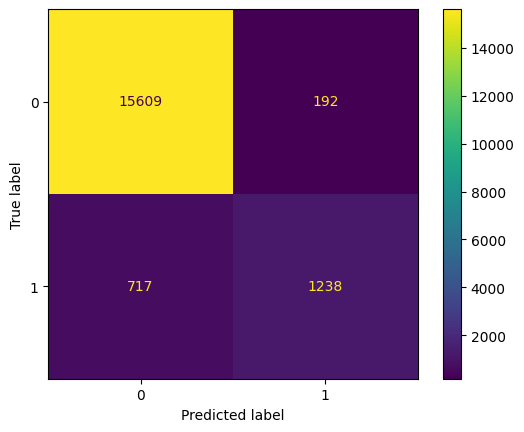

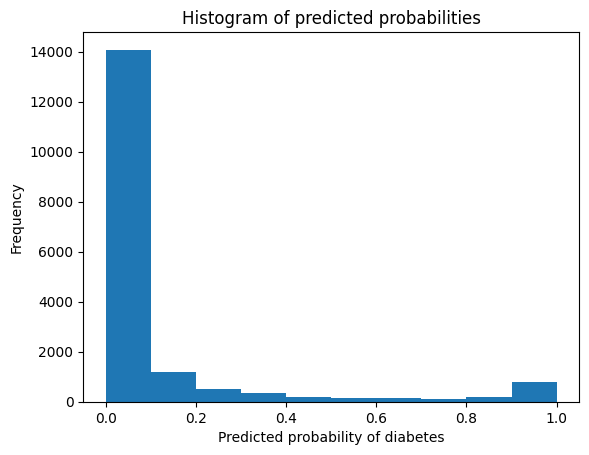

In [50]:
# Initializing and training the Logistic Regression model
tuned_LR_model = LogisticRegression(C = 0.1, max_iter= 1000, multi_class= 'ovr', penalty= 'l2', solver= 'lbfgs', tol= 0.01)
cv_scores = cross_val_score(tuned_LR_model, X_train, y_train, cv=5)
tuned_LR_model.fit(X_train, y_train)
LR_test_accuracy = tuned_LR_model.score(X_test, y_test)
print("Test Accuracy:", LR_test_accuracy)
print('Coefficients:', tuned_LR_model.coef_)

ConfusionMatrixDisplay.from_estimator(tuned_LR_model, X_test, y_test)
plt.show()

y_prob = tuned_LR_model.predict_proba(X_test)
plt.hist(y_prob[:,1], bins=10)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')
plt.show()

In [54]:
y_pred_LR = tuned_LR_model.predict(X_test)

LR_accuracy = accuracy_score(y_test, y_pred_LR)
LR_f1 = f1_score(y_test, y_pred_LR)
LR_precision = precision_score(y_test, y_pred_LR)
LR_recall = recall_score(y_test, y_pred_LR)

LR_check_probabilities = tuned_LR_model.predict_proba(X_check_ensemble)[:,1]
print(LR_check_probabilities[:12])

[5.36628593e-04 4.66816208e-03 1.00471500e-03 6.57768072e-03
 6.07530779e-03 3.03883702e-02 1.39874725e-01 3.33766606e-04
 1.60914760e-04 7.45182383e-01 2.79676404e-02 9.98356501e-01]


Accuracy:  0.9609146204100023
[[15733    68]
 [  626  1329]]


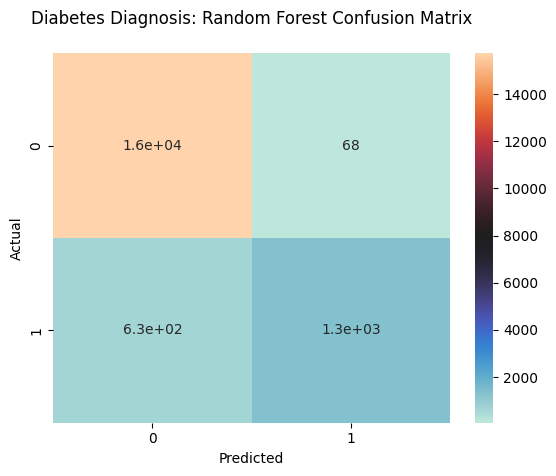

              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98     15801
    Positive       0.95      0.68      0.79      1955

    accuracy                           0.96     17756
   macro avg       0.96      0.84      0.89     17756
weighted avg       0.96      0.96      0.96     17756



In [57]:
y_trn_np = y_train.to_numpy()
y_trn_np_ravel = y_train.to_numpy().ravel()
forest = RandomForestClassifier()

#Fit to training data and labels
forest.fit(X_train, y_trn_np_ravel)

#Predict results and generate confusion matrix
forest_predicted = forest.predict(X_test)
forest.score(X_test, y_test)
accuracy = accuracy_score(y_test, forest_predicted)
print("Accuracy: ", accuracy)


confusion = confusion_matrix(y_test, forest_predicted)
print(confusion)
sns.heatmap(confusion, cmap = 'icefire', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Diabetes Diagnosis: Random Forest Confusion Matrix\n')
plt.show()

#Print classification report
target_names = ['Negative', 'Positive']
print(classification_report(y_test, forest_predicted, target_names = target_names))
tp = confusion[0][0]
fp = confusion[0][1]
tn = confusion[1][1]
fn = confusion[1][0]


In [60]:
def Best_Fit_Randomized(method, param_distributions, X_train, y_train, X_test, y_test):
    rand_search_method = RandomizedSearchCV(method, param_distributions=param_distributions, n_iter=30, verbose=1)
    best_fit = rand_search_method.fit(X_train, y_train)
    predicted = best_fit.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    return best_fit, accuracy, predicted, rand_search_method

In [61]:
n_estimators = np.arange(10, 900, 25)
criterion = ['gini', 'entropy']
max_depth = np.arange(4, 10, 1)
min_samples_split = np.arange(2, 8, 2)
min_samples_leaf = np.arange(1, 4, 1)
min_weight_fraction_leaf = np.arange(0, 0.5, 0.1)
max_features = ['sqrt', 'log2', None]
min_impurity_decrease = np.arange(0.00005, 0.01, 0.002)
bootstrap = [True, False]
class_weight = [None, 'balanced', 'balanced_subsample']

param_distributions = {'n_estimators':n_estimators, 'criterion':criterion, 'max_depth':max_depth,
                       'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf,
                       'min_weight_fraction_leaf':min_weight_fraction_leaf, 'max_features':max_features,
                       'min_impurity_decrease':min_impurity_decrease,
                       'bootstrap':bootstrap, 'class_weight':class_weight}

In [62]:
forest_opt = RandomForestClassifier()
best_fit_opt, accuracy_opt, predicted_opt, rand_search_opt = Best_Fit_Randomized(forest_opt, param_distributions, X_train, y_trn_np_ravel, X_test, y_test)
best_params_opt = best_fit_opt.best_params_
best_score_opt = best_fit_opt.best_score_
best_estimator_opt = best_fit_opt.best_estimator_
print("best_params", best_params_opt)
print("best_estimator", best_estimator_opt)

print("best_estimator.feature_importances_", best_estimator_opt.feature_importances_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
best_params {'n_estimators': 35, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.00805, 'max_features': None, 'max_depth': 4, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
best_estimator RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features=None,
                       min_impurity_decrease=0.00805, min_samples_leaf=3,
                       min_samples_split=4, n_estimators=35)
best_estimator.feature_importances_ [0.         0.         0.         0.         0.         0.
 0.60903221 0.39096779]


In [ ]:
print("Accuracy:", best_score_opt)

confusion_opt = confusion_matrix(y_test, predicted_opt)
print(confusion_opt)
sns.heatmap(confusion_opt, cmap = 'icefire', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Print classification report
target_names = ['Negative', 'Positive']
print(classification_report(y_test, predicted_opt, target_names = target_names))

In [ ]:
def Sort_Values(unsorted_array):
    pos = 0
    highest = -1
    ordered_array =[]
    pos_array = []
    while(len(ordered_array) < len(unsorted_array)): #Not all values entered
        for i in range(0, len(unsorted_array), 1):
            if(unsorted_array[i] >= highest):
                highest = unsorted_array[i]
                pos = i
        ordered_array.append(highest)
        pos_array.append(pos)
        unsorted_array[pos] = -2 #Ignore position in the future
        highest = -1
        pos = 0
            
    return pos_array, ordered_array

def Make_Pandas_Cols(head1):
    df = pd.DataFrame(columns=head1)
    for row in range(0, len(head1), 1):  #All cols except labels
        column = head1[row]
    
    return df

def Make_Pandas(array1, array2, head1):
    df = Make_Pandas_Cols(head1)
    df.loc["Unoptimized"] = array1
    df.loc["Optimized"] = array2

    return df

In [ ]:
#Sort features and importance percentages from highest to lowest for original and optimized

feature_orig = forest.feature_importances_
feature_opt = best_estimator_opt.feature_importances_
pos_array, ordered_array = Sort_Values(feature_orig)
print("Sorted original feature importance\n", pos_array)
print(ordered_array)
pos_array_opt, ordered_array_opt = Sort_Values(feature_opt)
print("Sorted optimized feature importance\n", pos_array)
print(ordered_array_opt)

In [ ]:
headers = []
unopt = []
opt = []
for i in range(0, len(pos_array), 1):
    headers.append(df.columns[pos_array[i]])
    unopt.append(ordered_array[i] * 100)
    opt.append(ordered_array_opt[i] * 100)
    feature_pd = Make_Pandas(unopt, opt, headers)
    feature_pd = feature_pd.round(decimals=4)
    vals = feature_pd.iloc[1]

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
plt.title = "Histogram of Feature Relevance to Diabetes Diagnosis"
plt.bar(headers, opt)

In [ ]:
Final_Outcome = X_test
Final_Outcome['actual'] = y_test
Final_Outcome['predicted'] = predicted_opt
Final_Outcome

In [63]:
y_pred_RFC = best_fit_opt.predict(X_test)

RFC_accuracy = accuracy_score(y_test, y_pred_RFC)
RFC_f1 = f1_score(y_test, y_pred_RFC)
RFC_precision = precision_score(y_test, y_pred_RFC)
RFC_recall = recall_score(y_test, y_pred_RFC)

RFC_check_probabilities = best_fit_opt.predict_proba(X_check_ensemble)[:,1]
print(RFC_check_probabilities[:12])

[0.         0.45170457 0.         0.         0.         0.45170457
 0.45170457 0.         0.         0.45170457 0.45170457 1.        ]


In [ ]:
#False negative cases, misdiagnosed as not diabetic
f_neg_df = Final_Outcome.loc[(Final_Outcome['actual'] == 1) & (Final_Outcome['predicted'] == 0)]
f_neg_df = f_neg_df.sort_values(by=['age'])
f_neg_df

In [ ]:
#Print normal ranges and data ranges
print("Normal BMI: 18.5 to 24.9")
print("Evaluated Range BMI: ", Final_Outcome['bmi'].min(), "to", Final_Outcome['bmi'].max())
print("False Negative Range BMI: ", f_neg_df['bmi'].min(), "to", f_neg_df['bmi'].max(), "\n")
pd.set_option('display.max_rows', None)
f_neg_low_bmi = f_neg_df.loc[(f_neg_df['bmi'] <= 30) & (f_neg_df['HbA1c_level'] > 5.7) & (f_neg_df['blood_glucose_level'] > 99)]

f_neg_low_bmi = f_neg_low_bmi.sort_values(by=['bmi'])
print(len(f_neg_low_bmi))
#f_neg_low_bmi

#Create histograms showing number of false negatives by BMI
plt.hist(f_neg_df['bmi'], bins='auto')
print("Approximate misdiagnoses by BMI:", len(f_neg_low_bmi)) 

In [ ]:
print("Normal HbA1c: 4% to 5.6%")
print("Evaluated Range HbA1c_level: ", Final_Outcome['HbA1c_level'].min(), "to", Final_Outcome['HbA1c_level'].max())
print("False Negative Range HbA1c_level: ", f_neg_df['HbA1c_level'].min(), "to", f_neg_df['HbA1c_level'].max(), "\n")

f_neg_low_hba1c_hi_glucose = f_neg_df.loc[(f_neg_df['HbA1c_level'] <= 5.7)
                                 & (f_neg_df['blood_glucose_level'] > 99)]
print(len(f_neg_low_hba1c_hi_glucose))
#f_neg_low_hba1c_hi_glucose

plt.hist(f_neg_df['HbA1c_level'], bins='auto')

print("Approximate misdiagnoses by HbA1c_level:", len(f_neg_low_hba1c_hi_glucose))

In [ ]:
f_neg_low_hba1c_hi_age = f_neg_df.loc[(f_neg_df['age'] > 70) 
                                      & (f_neg_df['HbA1c_level'] >= 5.7)
                                          & (f_neg_df['bmi'] <= 30)]
                                            
#f_neg_low_hba1c_hi_age

print("Evaluated Range Age: ", Final_Outcome['age'].min(), "to", Final_Outcome['age'].max())
print("False Negative Range Age: ", f_neg_df['age'].min(), "to", f_neg_df['age'].max(), "\n")
plt.hist(f_neg_df['age'], bins='auto')

print("Approximate misdiagnoses by age:", len(f_neg_low_hba1c_hi_age))

In [ ]:
estims = best_estimator_opt.estimators_

#Randomly choose 10 decision trees to display
random_nums = random.sample(range(0, 99), 10)
fig, axes = plt.subplots(nrows = 1, ncols = 5,figsize = (40,20))

print(random_nums)
for i in range(0, 5, 1):
    tree.plot_tree(estims[random_nums[i]], feature_names=X.columns, filled=True, ax = axes[i])
    
fig, axes = plt.subplots(nrows = 1, ncols = 5,figsize = (30,10))
for i in range(5, 10, 1):
    tree.plot_tree(estims[random_nums[i]], feature_names=X.columns, filled=True, ax = axes[i-5])

# ENSEMBLE COMBINATION

In [122]:
#Combine metrics from all models into lists for each metric type
ensemble_accuracies = [NN_accuracy[0], MLP_accuracy[0], float(LR_accuracy), float(RFC_accuracy)]
ensemble_f1 = [NN_f1[0], MLP_f1[0], float(LR_f1), float(RFC_f1)]
ensemble_precision = [NN_precision[0], MLP_precision[0], LR_precision, RFC_precision]
ensemble_recall = [NN_recall[0], MLP_recall[0], LR_recall, RFC_recall]

#Get errors of each metric in ensemble metrics lists by subtracting each metric from 1
ensemble_accuracy_errors = [1-acc for acc in ensemble_accuracies]
ensemble_f1_errors = [1-f1 for f1 in ensemble_f1]
ensemble_precision_errors = [1-prec for prec in ensemble_precision]
ensemble_recall_errors = [1-rec for rec in ensemble_recall]

# Combine the errors into a list where each element is the combined error for a given model
summed_errors = [
    acc_err + f1_err + prec_err + rec_err 
    for acc_err, f1_err, prec_err, rec_err 
    in zip(ensemble_accuracy_errors, ensemble_f1_errors, ensemble_precision_errors, ensemble_recall_errors)
]

#Take the inverse of errors, accounting for cases where error is 0
inverse_summed_errors = [1/err if err != 0 else 0 for err in summed_errors]

#Normalize the errors by dividing each model's summed error by the total to get weights
total_inverse_summed_errors = sum(inverse_summed_errors)
weights = [inv_err/total_inverse_summed_errors for inv_err in inverse_summed_errors]

#Take the predictions we made with each of the models on the check ensemble set, and using the weights, combine into one probability for each data point
ensemble_predictions = [
    float(NN_check_probabilities[i][0] * weights[0] + 
          MLP_check_probabilities[i] * weights[1] +
          LR_check_probabilities[i] * weights[2] +
          RFC_check_probabilities[i] * weights[3])
    for i in range(len(NN_check_probabilities))
]

print(ensemble_predictions)

[0.006278646656932495, 0.16759700877357084, 0.008638930420107082, 0.016033033564548316, 0.003405017473913943, 0.18415063360271172, 0.2728184429441194, 0.006962771760636179, 0.006123693118284519, 0.48728161845792484, 0.20684530032368642, 0.9985078830246867, 0.034717505113341415, 0.006376469068833351, 0.0320723740810818, 0.2699495878187513, 0.20273258510311343, 0.2840580463345571, 0.1790848717161975, 0.17743971696509517, 0.009805996788758905, 0.007733431365045661, 0.008062304649306297, 0.2535166820096887, 0.007276972884814927, 0.24292544002433025, 0.009745103981111187, 0.20072915256473706, 0.40564427214426474, 0.007853430715019033, 0.005286029634938766, 0.02148139145378317, 0.006094832343211966, 0.025970795342110633, 0.23942064048804085, 0.007400217814168647, 0.009266041885045003, 0.19489508522333066, 0.7411885075410787, 0.27528210770142636, 0.1753686072737126, 0.006066958430017064, 0.26212203146647994, 0.0049548680190249685, 0.17234575331529212, 0.017582146975521587, 0.9833429532215876,

In [127]:
#Debugging print statements to double check metrics (can delete)
print(ensemble_accuracies)
print(ensemble_f1)
print(ensemble_precision)
print(ensemble_recall)

print((NN_recall))
print((MLP_recall))
print((LR_recall))
print((RFC_recall))

[0.9600135165577833, 0.956127506195089, 0.9488060373958098, 0.9630547420590223]
0.7736720554272517
0.9970238095238095
0.6320754716981132
[0.6578005115089514]
[0.6388746803069054]
0.6332480818414322
0.6644501278772379


In [132]:
#Set the probability threshold for predicting if a data point has diabetes or not (0.6-0.65 tend to have the best overall results)
threshold = 0.6

#To determine ensemble metrics, change from probabilities to discrete class predictions
ensemble_y_pred = [1 if prob > threshold else 0 for prob in ensemble_predictions]

#Calculate metrics for the combined ensemble method
ensemble_accuracy = accuracy_score(y_check_ensemble, ensemble_y_pred)
ensemble_f1 = f1_score(y_check_ensemble, ensemble_y_pred)
ensemble_precision = precision_score(y_check_ensemble, ensemble_y_pred)
ensemble_recall = recall_score(y_check_ensemble, ensemble_y_pred)

print("Ensemble Accuracy:", ensemble_accuracy)
print("Ensemble F1 Score:", ensemble_f1)
print("Ensemble Precision:", ensemble_precision)
print("Ensemble Recall:", ensemble_recall)


Ensemble Accuracy: 0.9608
Ensemble F1 Score: 0.7736720554272517
Ensemble Precision: 0.9970238095238095
Ensemble Recall: 0.6320754716981132


In [161]:
#Combine probability predictions for each 
NN_probs = [prob[0] for prob in NN_check_probabilities]
MLP_probs = MLP_check_probabilities.tolist()
LR_probs = LR_check_probabilities.tolist()
RFC_probs = RFC_check_probabilities.tolist()


df_probs = pd.DataFrame({
    "True Value": y_check_ensemble.values.ravel(),
    "NN Probabilities": NN_probs,
    "MLP Probabilities": MLP_probs,
    "LR Probabilities": LR_probs,
    "RFC Probabilities": RFC_probs,
    "Ensemble Probabilities": ensemble_predictions
})

df_probs.tail(25)

,True Value,NN Probabilities,MLP Probabilities,LR Probabilities,RFC Probabilities,Ensemble Probabilities
4975,0,0.34031,0.12035,0.14730,0.45170,0.28075
4976,1,0.56280,0.36119,0.68379,0.45170,0.50680
4977,0,0.34042,0.10775,0.11187,0.45170,0.27054
4978,0,0.24087,0.01394,0.03512,0.45170,0.20600
4979,0,0.01732,0.00005,0.00001,0.00000,0.00461
4980,0,0.40868,0.45633,0.31378,0.45170,0.41329
4981,1,0.99630,0.99557,0.99969,1.00000,0.99789
4982,0,0.33397,0.22241,0.26026,0.45170,0.32652
4983,0,0.13760,0.00871,0.01226,0.45170,0.17266
4984,0,0.04541,0.03162,0.02602,0.00000,0.02494


In [160]:
#Combine the scores of each model (including ensemble) into a table for comparison
metrics_data = {
    'Model': ['NN', 'MLP', 'LR', 'RFC', 'Ensemble'],
    'Accuracy': [NN_accuracy[0], MLP_accuracy[0], LR_accuracy, RFC_accuracy, ensemble_accuracy],
    'F1 Score': [NN_f1[0], MLP_f1[0], LR_f1, RFC_f1, ensemble_f1],
    'Precision': [NN_precision[0], MLP_precision[0], LR_precision, RFC_precision, ensemble_precision],
    'Recall': [NN_recall[0], MLP_recall[0], LR_recall, RFC_recall, ensemble_recall]
}

df_metrics = pd.DataFrame(metrics_data)

print(df_metrics)

      Model  Accuracy  F1 Score  Precision  Recall
0        NN   0.96001   0.78367    0.96910 0.65780
1       MLP   0.95613   0.76228    0.94478 0.63887
2        LR   0.94881   0.73146    0.86573 0.63325
3       RFC   0.96305   0.79840    1.00000 0.66445
4  Ensemble   0.96080   0.77367    0.99702 0.63208
